# 필요 라이브러리 임포트

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.optim import SGD
from torchvision.transforms import transforms
from torchvision.models import efficientnet_b0
from PIL import Image
from tqdm import tqdm
import wandb
import os
from sklearn.metrics import accuracy_score

# 모델 정의 & 학습

In [14]:
# Initialize WandB
wandb.init(
    project="Fruit_recognition",
    name="EfficientNet_1st_train",
    dir="/students/vision002/team4/성엽/wandb",  # wandb 저장 경로 지정
    config={
        "learning_rate": 0.001,
        "epochs": 10,
        "batch_size": 32,
        "model": "EfficientNet-B0"
    }
)

# 데이터셋 클래스 정의
class FruitDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.classes = {"Apple": 0, "Banana": 1, "Orange": 2}
        self.images = []
        self.labels = []

        for label_name, label in self.classes.items():
            label_dir = os.path.join(root_dir, label_name)
            if os.path.exists(label_dir):
                for img_file in os.listdir(label_dir):
                    # 이미지 파일만 추가
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(label_dir, img_file))
                        self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            raise RuntimeError(f"Error loading image: {image_path}. {e}")

        if self.transforms:
            image = self.transforms(image)

        return image, label

# 데이터 로더 생성 함수
def get_data_loaders(batch_size=32, num_workers=4):
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dir = "/students/vision002/team4/data/Train"
    test_dir = "/students/vision002/team4/data/Test"

    # Train 데이터셋 로드 및 분할
    full_train_dataset = FruitDataset(train_dir, transforms=transform_train)
    train_size = int(0.8 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Test 데이터셋 로드
    test_dataset = FruitDataset(test_dir, transforms=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

# EfficientNet-B0 모델 초기화
def get_model(num_classes):
    model = efficientnet_b0(pretrained=True)
    
    # Freeze all layers except the classifier
    for param in model.parameters():
        param.requires_grad = False

    # Replace classifier layer
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# 학습 함수
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(data_loader, desc="Training", leave=True)
    for batch_idx, (images, labels) in enumerate(loop):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = torch.nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), accuracy=correct / total)

    accuracy = correct / total
    return total_loss / len(data_loader), accuracy

# 평가 함수
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(data_loader), accuracy

# 메인 실행 수정
if __name__ == "__main__":
    train_loader, val_loader, test_loader = get_data_loaders()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_model(num_classes=3).to(device)

    # 옵티마이저 설정
    optimizer = SGD(model.classifier[1].parameters(), lr=0.001, momentum=0.9)

    # 모델 저장 관련 설정
    best_accuracy = 0
    best_model_path = "EfficientNet_best_model_checkpoint.pth"

    num_epochs = 10
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss, train_accuracy = train_one_epoch(model, optimizer, train_loader, device)
        val_loss, val_accuracy = evaluate(model, val_loader, device)

        # 성능 개선 시 모델 저장
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved Best Model at Epoch {epoch + 1}")

        # WandB 로깅
        wandb.log({
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy
        }, step=epoch)

    wandb.finish()

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


Training: 100%|██████████| 57/57 [00:07<00:00,  7.82it/s, accuracy=0.859, loss=0.339]


Saved Best Model at Epoch 1
Epoch 2/10


Training: 100%|██████████| 57/57 [00:06<00:00,  9.22it/s, accuracy=0.981, loss=0.202]


Epoch 3/10


Training: 100%|██████████| 57/57 [00:05<00:00,  9.67it/s, accuracy=0.986, loss=0.194] 


Saved Best Model at Epoch 3
Epoch 4/10


Training: 100%|██████████| 57/57 [00:06<00:00,  9.13it/s, accuracy=0.99, loss=0.0544] 


Epoch 5/10


Training: 100%|██████████| 57/57 [00:05<00:00,  9.55it/s, accuracy=0.992, loss=0.0816]


Epoch 6/10


Training: 100%|██████████| 57/57 [00:06<00:00,  8.94it/s, accuracy=0.987, loss=0.0596]


Epoch 7/10


Training: 100%|██████████| 57/57 [00:06<00:00,  9.17it/s, accuracy=0.989, loss=0.0564]


Saved Best Model at Epoch 7
Epoch 8/10


Training: 100%|██████████| 57/57 [00:06<00:00,  9.39it/s, accuracy=0.996, loss=0.0869]


Epoch 9/10


Training: 100%|██████████| 57/57 [00:06<00:00,  8.99it/s, accuracy=0.992, loss=0.0375]


Epoch 10/10


Training: 100%|██████████| 57/57 [00:06<00:00,  9.21it/s, accuracy=0.991, loss=0.105] 


train_accuracy,▁▇▇███████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▁▇▇▇▇█▇██
val_loss,█▅▃▃▂▂▂▁▁▁
train_accuracy,0.99062
train_loss,0.0702
val_accuracy,1.0
val_loss,0.04145


# 모델 성능 평가

Test Loss: 0.5727
Test Accuracy: 76.03%
Confusion Matrix:
 [[239  13  38]
 [  0 200   0]
 [ 63  73 154]]


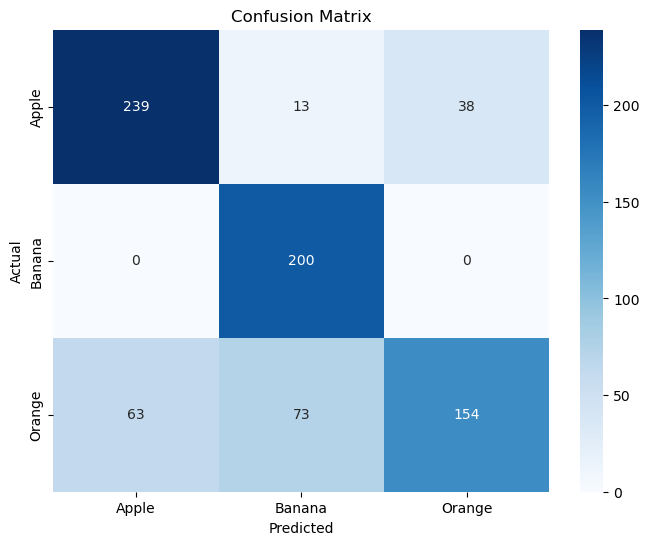


Classification Report:
               precision    recall  f1-score   support

       Apple       0.79      0.82      0.81       290
      Banana       0.70      1.00      0.82       200
      Orange       0.80      0.53      0.64       290

    accuracy                           0.76       780
   macro avg       0.76      0.79      0.76       780
weighted avg       0.77      0.76      0.75       780



In [15]:
# Confusion Matrix 및 테스트 평가
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 테스트 설정
def test_model(model_path, test_loader, device):
    # 모델 로드
    model = get_model(num_classes=3).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # 테스트 데이터 평가
    test_loss, test_accuracy, test_preds, test_labels = evaluate_with_predictions(model, test_loader, device)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Confusion Matrix 출력
    conf_matrix = confusion_matrix(test_labels, test_preds)
    print("Confusion Matrix:\n", conf_matrix)

    # Confusion Matrix 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Apple", "Banana", "Orange"], yticklabels=["Apple", "Banana", "Orange"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report 출력
    print("\nClassification Report:\n", classification_report(test_labels, test_preds, target_names=["Apple", "Banana", "Orange"]))

# 예측 포함 평가 함수
def evaluate_with_predictions(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return total_loss / len(data_loader), accuracy, all_preds, all_labels

# 모델 테스트 실행
if __name__ == "__main__":
    test_model("EfficientNet_best_model_checkpoint.pth", test_loader, device)